In [1]:
# Standard Libraries
import pandas as  pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = '1'
%matplotlib inline
import time
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import re
import io
from scipy import sparse as sp
from scipy.sparse.linalg import norm
from collections import defaultdict
from inspect import signature
import sklearn.preprocessing as pp
from IPython.display import Image, display, HTML

from tqdm.notebook import tqdm
import warnings

# ML import
from sklearn import datasets        # datasets
from sklearn.cluster import KMeans  # K-Means algorithm
from sklearn.cluster import AgglomerativeClustering  # Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage # dendogram visualization

# Import from mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Set some formatting options
plt.style.use('dark_background')
np.set_printoptions(threshold=500, precision=4)
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 20

# Import from surprise library
from surprise import Dataset, Reader, accuracy
from surprise import get_dataset_dir
from surprise import KNNBasic, KNNWithMeans, SVD
from surprise.model_selection import train_test_split 
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.accuracy import rmse
from surprise import model_selection

# Assignment 2

Welcome to the second assignment! 

You will have to implement clustering, association rules, and recommender systems algorithms, applying these methods to: 
- explore the similarities within groups of people watching movies (clustering analysis)
- discover the relations between movies genre (association rules)
- recommend movies to users (recommender system)

We will use the MovieLens dataset, which contains movie ratings collected from the MovieLens website by the [GroupLens](https://grouplens.org/) research lab.

Source: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

Once you are done you have to submit your notebook here: 
[https://moodle.epfl.ch/mod/assign/view.php?id=1247726](https://moodle.epfl.ch/mod/assign/view.php?id=1247726)

If there is need for further clarifications on the questions, after the assignment is released, we will update this file, so make sure you check the git repository for updates.

Good luck!

## Clustering analysis: similarities between people (10 points)

In this section, you will try to form clusters of individuals based on their preferences regarding movie genres. You will use a transformed version of the MovieLens dataset containing, for a selection of users:
- their average rating of all science fiction movies they rated,
- their average rating of all comedy movies they rated.

Better understanding the differences in people's tastes can help improve the design of recommender systems, for instance for the creation of the user neighborhood. Ok, let's start!

- Load the data in a dataframe. The url link is provided below. Display the first 10 observations.

In [2]:
url_clustering = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/ratings_clustering.csv'
movies_tastes= pd.read_csv(url_clustering)
warnings.simplefilter(action='ignore', category=FutureWarning)
movies_tastes.head(10)

,avg_scifi_rating,avg_comedy_rating
0,3.50,2.71
1,2.56,2.64
2,2.00,3.20
3,3.18,2.83
4,3.00,3.90
5,2.33,3.20
6,3.00,3.63
7,2.30,3.40
8,3.11,3.39
9,2.85,2.47


- Plot a dendogram using "ward" as linkage method and "euclidean" as metric. 
- Based on the dendogram, how many clusters do you think is optimal? Briefly justify your answer.

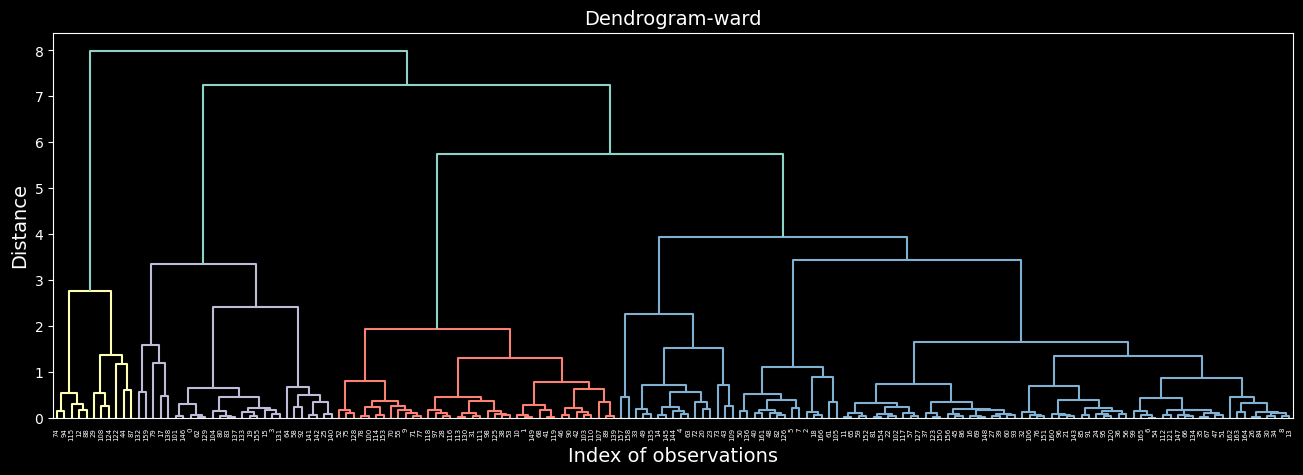

In [3]:
# Plot the dendogram with ward linkage and euclidean metric
Z = linkage(movies_tastes, 'ward', metric='euclidean')

plt.figure(figsize=(16, 5))
plt.title('Dendrogram-ward', fontsize=14)
plt.xlabel('Index of observations', fontsize=14)
plt.ylabel('Distance', fontsize=14)
dendrogram(Z, leaf_rotation=90.)
plt.show()

#### Comment on the results:

Upon reviewing the dendrogram, I have concluded that the optimal number of clusters would be **4**. 

To determine the optimal number of clusters from the dendrogram, I drew an imaginary horizontal line through the longest stretch of vertical lines that were not crossed by any true horizontal line (as explained in lecture 5 in the theoretical class of Machine Learning). Then, by counting the number of vertical lines that this imaginary line crossed, I arrived at the conclusion that the optimal number of clusters would be 4.

- Implement the Elbow method to determine the optimum number of cluster for K-Means algorithm (use `random_state=17` as parameter of K-Means). 
- Based on the Elbow method, how many clusters do you think is optimal? Briefly justify your answer.

Before applying the Elbow method, we need to define the KMeans algorithm, which is a clustering method that partitions a dataset into K clusters. In this case, even if we obtained that the optimal k is equal to 4, we have set the initial number of clusters to 3, just for representation and comparison.

In [4]:
# Create an instace of KMeans and specify the number of clusters=3, 
kmeans3 = KMeans(n_clusters=3, random_state=17, n_init='auto') #3 clusters

# Fit the model
kmeans3.fit(movies_tastes)

KMeans(n_clusters=3, n_init='auto', random_state=17)

In [5]:
print(kmeans3.labels_)
print(kmeans3.cluster_centers_)

[2 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 2 1 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 1 2 0 2 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 2 0 0 0 0 0 0 0 1 1 0 0 0 2 0 1 0 0 0 0 0 0 2 0 0 0 1 0 1 1 1 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 2 0 0 2 0 0 0 1 0 2 0 2 2 2 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1]
[[2.9015 3.1675]
 [1.713  3.4504]
 [3.8771 2.4212]]


We now try to find the "optimal" number of clusters using the Elbow method.
To do so, we will use the inertia.

In the context of clustering, **inertia** is a metric that calculates the sum of squared distances between each data point and its closest centroid in a given set of clusters. It is used to evaluate the quality of clustering and serves as the cost function that clustering algorithms aim to minimize. 

A lower value of inertia indicates that the clusters are more tightly packed and therefore better defined.

In [6]:
print("The inertia of the K-Means model with 3 clusters is: {:0.2f}".format(kmeans3.inertia_))

The inertia of the K-Means model with 3 clusters is: 60.45


Let's explore how many clusters should we pick using the Elbow method.

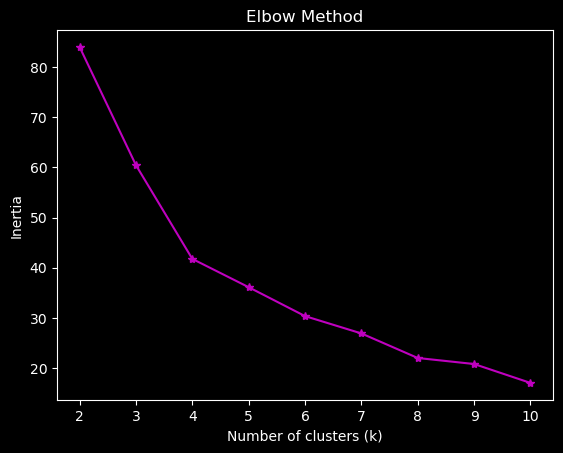

In [7]:
# Compute inertia for different values of k
inertia = []
nbr_clusters = range(2,11)
for k in nbr_clusters:
    kmeans = KMeans(n_clusters=k, random_state=17, n_init='auto')
    kmeans.fit(movies_tastes)
    inertia.append(kmeans.inertia_)

# plot SSE as a function of k
plt.plot(nbr_clusters, inertia, 'm*-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

#### Comment on the results:

Based on the resulting plot, we can look for the elbow point. This is the point where the SSE starts to level off, indicating that the additional clusters do not contribute significantly to reducing the distance between the data points and their assigned cluster centers. In this case, it appears that the elbow point is at k=4, since the decrease in SSE slows down significantly beyond this point. Therefore, we can conclude that 4 clusters may be the optimal number for this dataset.

- Implement (train) a K-Means algorithm with the number of clusters of your choice. Use `random_state=17` as parameter.

We will now train a K-Means algorithm with k=4, which is the optimal number of clusters suggested by both the dendrogram and the elbow method.

In [8]:
# Create an instace of KMeans and specify the number of clusters=4, 
# Random state help make sure we all have exactly the same results
kmeans4 = KMeans(n_clusters=4, random_state=17, n_init='auto') #3 clusters

# Fit the model
kmeans4.fit(movies_tastes)

KMeans(n_clusters=4, n_init='auto', random_state=17)

Out of curiosity, I will display the inertia for k=4 and compare it to that of k=3.

In [9]:
print("The inertia of the K-Means model with 4 clusters is: {:0.2f}".format(kmeans4.inertia_))

The inertia of the K-Means model with 4 clusters is: 41.75


The observed decrease in inertia indicates that the clusters are more tightly packed, implying that they are better defined.

- Implement (train) a hierarchical algorithm with the same number of clusters as for the K-Means model. Use "ward" as linkage method and "euclidean" as metric/affinity 

`ward`: minimizes the variance of the clusters being merged

In [10]:
# Create AgglomerativeClustering object with desired parameters
hierarchical4 = AgglomerativeClustering(n_clusters=4, linkage='ward', affinity='euclidean')

# Fit the model to your data
hierarchical4.fit(movies_tastes)

AgglomerativeClustering(affinity='euclidean', n_clusters=4)

- Create a figure consisting of two subplots:
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your KMeans model. Add the cluster centers to your plot. Label your clusters with the name of your choice (e.g., "Comedy aficionado").
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your hierarchical algorithm model. Label your clusters with the name of your choice.
- How do your models compare?

In [11]:
hierarchical4_labels = hierarchical4.fit_predict(movies_tastes)

cluster_centers = []
for i in np.unique(hierarchical4_labels):
    cluster_centers.append(np.mean(movies_tastes[hierarchical4_labels == i], axis=0))

In [12]:
kmeans4_cluster_labels = ['Likes both equally', 'Comedy fan', 'Scifi fan', 'Prefers comedy slightly more']
hierarchical4_cluster_labels = ['Prefers comedy slightly more', 'Comedy fan', 'Scifi fan', 'Likes both equally']

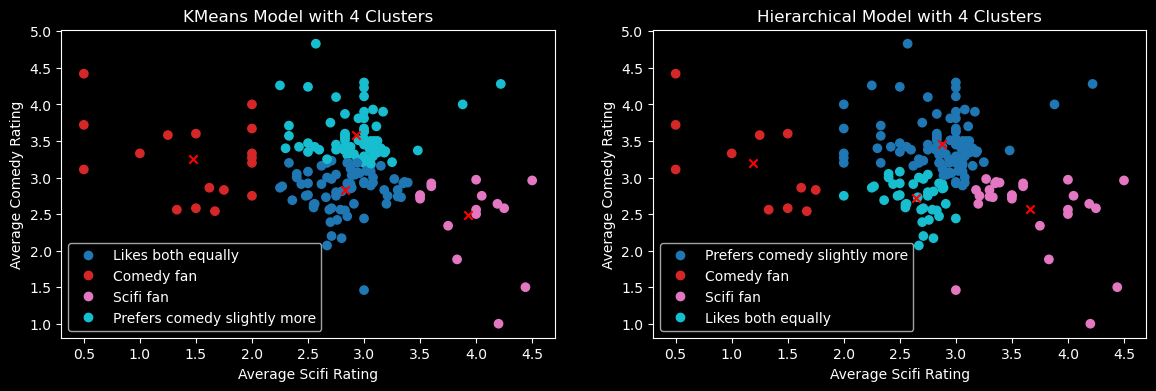

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Scatter plot of clusters, KMeans Model with 4 Clusters
scatter = ax[0].scatter(movies_tastes["avg_scifi_rating"], 
                        movies_tastes["avg_comedy_rating"], 
                        c=kmeans4.labels_, 
                        cmap='tab10', 
                        label=kmeans4_cluster_labels)
ax[0].scatter(kmeans4.cluster_centers_[:, 0],
              kmeans4.cluster_centers_[:, 1],
              c="red", 
              marker='x')
ax[0].set_xlabel("Average Scifi Rating")
ax[0].set_ylabel("Average Comedy Rating")
ax[0].set_title("KMeans Model with 4 Clusters")
ax[0].legend(handles=scatter.legend_elements()[0], labels=kmeans4_cluster_labels)

# Scatter plot of clusters, hierarchical clustering with 4 Clusters
ax[1].scatter(movies_tastes["avg_scifi_rating"],
              movies_tastes["avg_comedy_rating"],
              c=hierarchical4.labels_,
              cmap='tab10',
              label=hierarchical4_cluster_labels)
for i in range(len(cluster_centers)):
    ax[1].scatter(cluster_centers[i][0], cluster_centers[i][1], c="red", marker='x')
ax[1].set_xlabel("Average Scifi Rating")
ax[1].set_ylabel("Average Comedy Rating")
ax[1].set_title("Hierarchical Model with 4 Clusters")
ax[1].legend(handles=scatter.legend_elements()[0], labels=hierarchical4_cluster_labels)

fig.subplots_adjust(wspace=0.2)
plt.show()

#### Comment on the results:
Based on the two figures, it appears that the centroids of the KMeans and hierarchical models are placed in similar positions. 

However, there are some differences in the clustering of the points. Specifically, the size of the "Likes both equally" cluster (dark blue) decreases in the hierarchical model (light blue), while the "prefers comedy slightly more" cluster (light blue in KMeans and dark blue in hierarchical) increases. Additionally, the "comedy fan" cluster (red) decreases in the hierarchical model, while the "Scifi fan" cluster (pink) increases.

## Association Rules: association between movie genres (10 points)

You will now pursue your analysis, but this time trying to dig out information about movies. More precisely, you will search for matches between film genres using association rules. We try to understand, for instance, how likely it is that a film is both drama and action. This information can be interesting for film producers who may either want to produce something similar to the established norm: if most drama films are also action, perhaps the new action-drama film would be equally appreciated, or quite to the contrary try a new combination of genres which is more rare to find.

- Load the data in a dataframe. The url link is provided below. 
- Display the first 10 observations. 
- Print the unique values of genres from the first column. 
- How many unique genres does the first column contain? 
- How many movies does the dataframe contains?

In [14]:
url_movies = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/movies_assoc_rules.csv'
movies = pd.read_csv(url_movies)
warnings.simplefilter(action='ignore', category=FutureWarning)
movies.head(10)

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN
1,Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Action,Crime,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adventure,Children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Action,Adventure,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Print the unique values of genres from the first column
unique_genres = movies['0'].unique()
print('The dataset contains these genres: '+', '.join(unique_genres))

The dataset contains these genres: Adventure, Comedy, Action, Drama, Crime, Children, Mystery, Documentary, Animation, Thriller, Horror, Fantasy, Western, Film-Noir, Romance, War, Sci-Fi, Musical, IMAX


In [16]:
# How many unique genres does the first column contain?
num_unique_genres = len(unique_genres)
print("The first column contains", num_unique_genres, "unique genres.")

The first column contains 19 unique genres.


In [17]:
# How many movies does the dataframe contains?
num_movies = movies.shape[0]
print("The dataframe contains", num_movies, "movies.")

The dataframe contains 27032 movies.


- Preprocessing: as seen during the lab, convert the dataset using a `Transaction Encoder` from the `mlextend` module so that the dataset is reorganised in columns of unique genres. Rows should contain only True or False boolean values according to whether a film was considered as belonging to a genre column or not. Check that you have the correct dimensions.

In [18]:
# Convert dataframe to list of list
movies_list = movies.values.tolist()

# Remove NaNs with list comprehensions
movies_list_cleaned = [[x for x in y if str(x) != 'nan'] for y in movies_list]

In [19]:
print(movies_list_cleaned[0])
print(movies_list_cleaned[4])

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']
['Comedy']


In [20]:
# Create instance of Encoder
te = TransactionEncoder()

# Fit encoder and transform our list
movies_list_encoded = te.fit(movies_list_cleaned).transform(movies_list_cleaned)

# Create dataframe with results
movies_encoded = pd.DataFrame(movies_list_encoded, columns=te.columns_)
movies_encoded.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [21]:
# Check that it has the expected dimensions (27032 rows/movies and 19 columns/genres)
print(movies_encoded.shape)

(27032, 19)


- Frequent itemsets: using the Apriori algorithm to find the frequent itemsets with minimum support of 0.01. There is no condition on the maximum length of an itemset. 
- How many itemsets did the apriori algorithm return above (for min_support=0.01)? 
- What are the 10 itemsets with the largest support (you can directly display a dataframe with the 10 itemsets and their support)?

In [22]:
# Calculate frequent itemsets with minimum support of 0.01
freq_items = apriori(movies_encoded, min_support=0.01, use_colnames=True)

# How many itemsets did the apriori algorithm return above?
num_items = freq_items.shape[0]
print("The apriori algorithm returned", num_items, "itemsets with minimum support of 0.01.")

# What are the 10 itemsets with the largest support?
top_10_items = freq_items.nlargest(10, 'support')
display(top_10_items)

The apriori algorithm returned 69 itemsets with minimum support of 0.01.


,support,itemsets
7,0.493637,(Drama)
4,0.309781,(Comedy)
15,0.154558,(Thriller)
13,0.152671,(Romance)
0,0.130216,(Action)
5,0.108723,(Crime)
10,0.096589,(Horror)
53,0.095183,"(Romance, Drama)"
39,0.094185,"(Drama, Comedy)"
6,0.091410,(Documentary)


1) Mining for association rules: using the frequent items identified above, find association rules with a minimum confidence of 0.45 and order them by decreasing value of lift.

2) Discuss the following statements (true or false with 1-2 lines justification)
    
    - Animation films are associated with Children.  
    
    - If a film has the genre Musical, then it is also a Comedy.
    
    - If War then Drama is the asociation rule with the highest confidence.  

In [23]:
# Generate rules
movies_rules = association_rules(freq_items, metric="confidence", min_threshold=0.45)

# Rules sorted by lift
movies_rules_sorted = movies_rules.sort_values(by="lift", ascending=False)

movies_rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Animation),(Children),0.037992,0.042135,0.017387,0.457644,10.861301,0.015786,1.766117
8,(Mystery),(Thriller),0.056008,0.154558,0.029410,0.525099,3.397434,0.020753,1.780250
9,"(Crime, Action)",(Thriller),0.028374,0.154558,0.014612,0.514993,3.332050,0.010227,1.743157
11,"(Mystery, Drama)",(Thriller),0.026672,0.154558,0.012800,0.479889,3.104921,0.008677,1.625504
2,(Musical),(Comedy),0.038325,0.309781,0.018238,0.475869,1.536146,0.006365,1.316882
7,(War),(Drama),0.044170,0.493637,0.033072,0.748744,1.516790,0.011268,2.015324
1,(Children),(Comedy),0.042135,0.309781,0.019458,0.461809,1.490758,0.006406,1.282479
3,(Romance),(Comedy),0.152671,0.309781,0.070102,0.459171,1.482245,0.022808,1.276225
6,(Romance),(Drama),0.152671,0.493637,0.095183,0.623455,1.262983,0.019819,1.344762
4,(Crime),(Drama),0.108723,0.493637,0.063332,0.582511,1.180039,0.009663,1.212877


In [24]:
# Rules sorted by confidence
movies_rules_sorted.sort_values(by="confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(War),(Drama),0.044170,0.493637,0.033072,0.748744,1.516790,0.011268,2.015324
6,(Romance),(Drama),0.152671,0.493637,0.095183,0.623455,1.262983,0.019819,1.344762
4,(Crime),(Drama),0.108723,0.493637,0.063332,0.582511,1.180039,0.009663,1.212877
10,"(Crime, Thriller)",(Drama),0.045576,0.493637,0.025192,0.552760,1.119769,0.002695,1.132194
8,(Mystery),(Thriller),0.056008,0.154558,0.029410,0.525099,3.397434,0.020753,1.780250
9,"(Crime, Action)",(Thriller),0.028374,0.154558,0.014612,0.514993,3.332050,0.010227,1.743157
11,"(Mystery, Drama)",(Thriller),0.026672,0.154558,0.012800,0.479889,3.104921,0.008677,1.625504
5,(Mystery),(Drama),0.056008,0.493637,0.026672,0.476222,0.964721,-0.000975,0.966751
2,(Musical),(Comedy),0.038325,0.309781,0.018238,0.475869,1.536146,0.006365,1.316882
1,(Children),(Comedy),0.042135,0.309781,0.019458,0.461809,1.490758,0.006406,1.282479


*Discuss statements here* 

**Animation films are associated with Children**
True. Upon examining the first row, we can see that there is a strong association or high lift between Animation and Children.
The association rule between "Animation" and "Children" has a confidence of 0.457, which indicates that 45.7% of the transactions that contain "Animation" also contain "Children". This could be in some sense expected, since cartoons are normally addressed to children.

**If a film has the genre Musical, then it is also a Comedy**
False. Although the association rule between "Musical" and "Comedy" has a high confidence of 0.476, it is important to note that correlation does not imply causation. Actually, we can see that the lift is not that high (1.536). This means that the presence of "Musical" does not necessarily mean that the film is also a "Comedy".

**If War then Drama is the asociation rule with the highest confidence.**
True. The association rule between "War" and "Drama" has the highest confidence of 0.749, which indicates that 74.9% of the transactions that contain "War" also contain "Drama". You can appreciate it in the second table that it is sorted by confidence.

## Recommender systems: item-based recommender system (10 points)

In the walkthrough, we have implemented a user-to-user collaborative filtering algorithm (from scratch and using using Surprise library), i.e., our recommendations were based on the ratings of users with similar tastes. In this assignment, you will implement an **item-to-item** collaborative filtering algorithm, i.e., the recommendations will be based on the set of movies that users like. Do not worry, you won't have to implement the algorithm from scratch and instead can rely on the [Surprise library](http://surpriselib.com/). 

- As in the walkthrough, load the *built-in* `ml-100k` from the Surprise library.

In [25]:
# Load data
data = Dataset.load_builtin('ml-100k')

- Use GridSearchCV to find the best number of neighbors (k) for a KNNWithMeans **item-based** algorithm, with the following parameters:
    - options for k: `[10, 20, 30, 40, 50]`
    - `'sim_options': {'name': ['pearson'], 'user_based': [???]}` Here you have to replace `???` with the appropriate value...
    - root-mean-square-error (RMSE) as measures,
    - 5 cross-validation folds,
    - other parameters: `refit=True, joblib_verbose=2, n_jobs=-1`
- What is the optimal k for which GridSearchCV returned the best RMSE score? 
- What is the RMSE score for the optimal k?

In [26]:
# Define parameters to test
param_grid={'k': [10, 20, 30, 40, 50], 'sim_options': {'name': ['pearson'], 'user_based': [False]}}

# Use GridSearchCV with 5 cross-validation folds
KNN_grid_search = GridSearchCV(KNNWithMeans, param_grid = param_grid, measures = ['RMSE'], cv=5,
                               refit = True, joblib_verbose = 2, n_jobs = -1)

KNN_grid_search.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   46.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   51.8s finished


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [27]:
# Print the results
print('Best parameters:', KNN_grid_search.best_params)
print('Best RMSE: ', KNN_grid_search.best_score)

Best parameters: {'rmse': {'k': 50, 'sim_options': {'name': 'pearson', 'user_based': False}}}
Best RMSE:  {'rmse': 0.9392626347223964}


- Using the Surprise library, split your dataset between training and test set. As parameters, use `test_size=0.2, random_state=12`
- Fit a KNNWithMeans algorithm using the best k value retrieved above. As other parameters, use:
    - `min_k=1`
    - `sim_options = {'name': 'pearson','user_based': ???}`
    - `verbose=False`
- Predict ratings on the test set using your algorithm

The 'user_based' parameter is a setting for collaborative filtering algorithms in the surprise library. This parameter tells the algorithm whether it should recommend items to a user based on the preferences of other **users** who are similar to them, or based on the similarity between the **items** themselves.

If user_based=True, the algorithm will recommend items based on the similarity between the preferences of the user and other similar users. However, if user_based=False, the algorithm will recommend items based on the similarity between the items themselves.

In this case, we will use Item-to-item filter. Consequently, I will set the user-based value to False.

In [28]:
# Split the dataset into a training set and a test set
trainset, testset = model_selection.train_test_split(data, test_size=0.2, random_state=12)

# Fit a KNNWithMeans algorithm using the best k value retrieved from the grid search
algo = KNNWithMeans(k=50, min_k=1, sim_options={'name': 'pearson', 'user_based': False}, verbose=False)
algo.fit(trainset)

# Predict ratings on the test set using the trained algorithm
predictions = algo.test(testset)

# Compute and print Root Mean Squared Error (RMSE)
rmse = accuracy.rmse(predictions)
print('RMSE:', rmse)

RMSE: 0.9378
RMSE: 0.9377831339431245


#### Comment on the results:
Considering that the RMSE metric is an indicator of the quality of a model's predictions, with lower values indicating better performance, it can be observed that a slight improvement has been achieved. Specifically, the original model (using GridSearchCV) had an RMSE value of 0.9394, while the updated approach (using the Surprise library) resulted in a lower value of 0.9378.

- Use the helper function below to identify the best 10 films for all users
- Find the top 10 predictions for user 169 (you should return the titles of the movies)

Here are the output we get:
- `uid` is the user id
- `iid` is the item id
- `r_ui` is the true rating
- `est` is the estimated rating

In [29]:
def read_item_names():
    '''Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    '''

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list) # This is used to group a sequence of key-value pairs into a dictionary of lists
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [30]:
# Get top 10 movies for all users
top10_all_users = get_top_n(predictions, n=10)
top10_user_169 = top10_all_users['169']

# Read the mappings row id <-> movie name
movie_names = read_item_names()

# Print the best 10 films for all users
top10_all_users

defaultdict(list,
            {'490': [('9', 3.650891371240792),
              ('258', 3.5930508129309517),
              ('181', 3.4133467997834206),
              ('292', 3.3880712280572998),
              ('7', 3.3463087987334856),
              ('126', 3.202289207827309),
              ('117', 3.1800578351875726),
              ('293', 3.1696799881556386),
              ('547', 3.1418622695049145),
              ('277', 3.1052917682733563)],
             '533': [('174', 4.308280424994466),
              ('408', 4.216940214754803),
              ('169', 4.148904393048197),
              ('172', 4.096986275167353),
              ('98', 4.037252387903187),
              ('496', 4.020163464070305),
              ('527', 3.9148445150581295),
              ('8', 3.8733027057242877),
              ('480', 3.8598485581396806),
              ('19', 3.8558884342259656)],
             '460': [('127', 4.066575384290159),
              ('124', 4.035529000720994),
              ('306', 3.8588087

In [31]:
# Print the recommended items for user id 169
top10_user_169

[('603', 4.912368879860058),
 ('483', 4.77394325293519),
 ('499', 4.645022056516529),
 ('134', 4.625057166545083),
 ('480', 4.523838765645649),
 ('525', 4.379442869070362),
 ('482', 4.354374408036416),
 ('495', 4.284338338006693),
 ('204', 4.269411686333058),
 ('443', 4.265509524587903)]

In [32]:
# First recommended movie
movie_names[0][top10_user_169[0][0]]

'Rear Window (1954)'

In [33]:
# Create a loop for having the first 10 recommendations
print("Top 10 for user 169:")
print()
for movie_id in top10_user_169:
    print(movie_names[0][movie_id[0]])

Top 10 for user 169:

Rear Window (1954)
Casablanca (1942)
Cat on a Hot Tin Roof (1958)
Citizen Kane (1941)
North by Northwest (1959)
Big Sleep, The (1946)
Some Like It Hot (1959)
Around the World in 80 Days (1956)
Back to the Future (1985)
Birds, The (1963)


#### Comment on the results:
As we can see, these films are considered to be classics in the history of cinema and have been well-received by both critics and audiences. They were produced between 1941 and 1985 and span multiple genres, including drama, romance, thriller, and comedy.

- Plot the precision at rank k and the recall at rank k on the same figure, for k between 0 and 20, and a relevance threshold of 3.75
- Plot the precision-recall curve

*You can, but do not have to, rely on the function(s) used in the lab (i.e., copying the code of the function(s))*

We can evaluate the performance of our recommender using the precision and recall at rank k.

In [34]:
def precision_recall_at_k(predictions, k=20, threshold=3.75):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

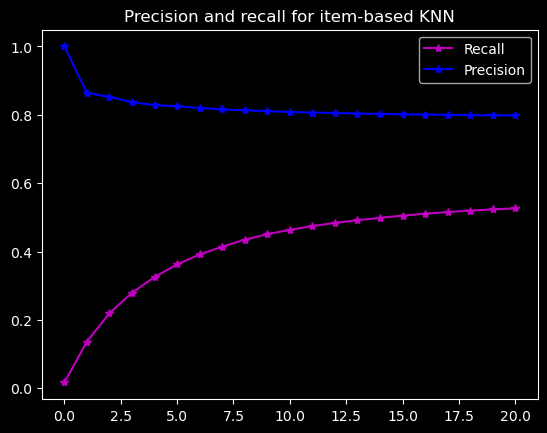

In [35]:
#Compute precision and recall for k between 0 and 9
precision = []
recall = []
for k in range(21):
    #rating > 3.75 = relevant, rating < 3.75 = irrelevant
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.75)
    #Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

#Plot
plt.plot(range(21), recall, 'm*-', label="Recall")
plt.plot(range(21), precision, 'b*-', label="Precision")
plt.legend()
plt.title("Precision and recall for item-based KNN")
plt.show();

In [36]:
#Precision and recall at rank 20:
precisions, recalls = precision_recall_at_k(predictions, k=20, threshold=3.5)
print("Precision of k=20 for item-based knn", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall of k=20 for item-based knn", sum(rec for rec in recalls.values()) / len(recalls))

Precision of k=20 for item-based knn 0.7383613488052115
Recall of k=20 for item-based knn 0.6659478601044678


#### Comment on the results:

The graph indicates that the Precision of the model remains stable at approximately 0.8. The minimum Precision value, which occurs at k=20, is 0.7383, which is near 0.8. This precision stays relatively constant because the model is recommending items that are similar to the ones the user has already rated highly. 

In contrast, the Recall values experience a steep increase until k=5, after which they continue to increase but at a slower rate.

Let's plot our precision-recall curves for our two algorithms:

In [37]:
def precision_recall_algo(algo):
    '''Return precision and recall at k metrics for an algorithm.'''    
    
    # Fit algo on training set
    algo.fit(trainset)
    
    # Predict on test set
    predictions = algo.test(testset)
    
    # Compute precision and recall
    precision = []
    recall = []
    for k in range(20):
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.75)
        precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
        recall.append( sum(rec for rec in recalls.values()) / len(recalls) ) 
    
    return precision, recall

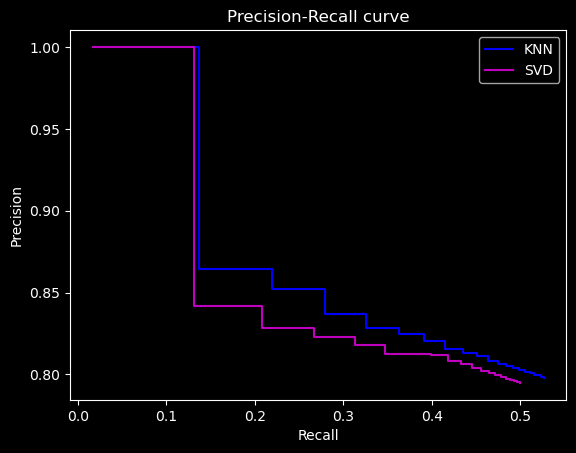

In [38]:
# KNN precision and recall
precision_KNN, recall_KNN = precision_recall_algo(algo)

# SVD precision and recall
algo_SVD = SVD()
precision_SVD, recall_SVD = precision_recall_algo(algo_SVD)

# Plot
plt.step(recall, precision, color='b', where='post', label ='KNN')
plt.step(recall_SVD, precision_SVD, color='m', where='post', label ='SVD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve');

#### Comment on the results:
In the present graph, it is necessary to examine the region below the lines.

The graph depicts that the KNN's precision-recall curve, represented by the blue line, is positioned above the SVD's curve, which is represented by the purple line. As a result, the area under the KNN's curve is greater than the area under the SVD's curve.

This means that the KNN algorithm is performing better than the SVD algorithm in terms of precision and recall. This implies that KNN is able to recommend more relevant items to the users with a higher accuracy compared to SVD.

*Take into account that this graph slightly changes when we re-run the notebook*

### Personal conclusions
In conclusion, this assignment provided me with a valuable learning opportunity, allowing me to deepen my understanding of the theoretical concepts taught in class. Unlike the previous assignment, I did not find this one to be repetitive, making it more helpful and engaging.

##### Sources:
Sources utilized for this project include the notebooks for the current course and the previous semester's course. Additionally, Chat GPT and pandas website help me resolve errors in my code.

Congrats, you are done with the assignment!